### Instructions
This script is for training a binary classification model CNN from the given dataset using Keras + Tensorflow stack.
1. Configure the paramers as required
2. Configure the model as required
3. Run all the cells (cell > Run all)

### Imports

imports the required modules from keras, Tensorflow, PIL, numpy and custom file handling functions

In [2]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers.convolutional import Conv2D, MaxPooling2D, ZeroPadding2D, SeparableConv2D
from keras.datasets import mnist
from keras.utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
from keras import optimizers, regularizers, models, layers
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.applications import VGG16
from random import shuffle, randint
import numpy as np
from PIL import Image

import matplotlib.pyplot as plt
import os, shutil
from os import listdir
from os.path import isfile, join
from keras.models import load_model, model_from_json
from pathlib import Path
from utils.file_utils import make_dir_helper, delete_dir_helper, is_jpeg

### Configurable parameters

Defines various constants, directory paths and design of the model

In [3]:
project_dir_name = 'Esri Project'
base_scripts_dir =  join(os.path.expanduser('~'), 'Desktop', project_dir_name, 'scripts');
model_dir =  join(os.path.expanduser('~'), 'Desktop', project_dir_name, 'models');

POSITIVE_CLASS = 'roads'
NEGATIVE_CLASS = 'others'
MODEL_FILE_NAME = POSITIVE_CLASS + '_binary_classifer_model.h5'
ext = '.jpg'
IMAGE_SIZE = 128
EPOCHS = 20
BATCH_SIZE = 10
STEPS_PER_EPOCH = 100
PERCENT_TRAINING_SAMPLES = 0.70

original_dataset_dir = join(os.path.expanduser('~'),'Desktop', project_dir_name, 'datasets', 'redlands dataset');
positive_dataset_dir = join(original_dataset_dir, POSITIVE_CLASS)
negative_dataset_dir = join(original_dataset_dir, NEGATIVE_CLASS)

base_data_dir =  join(os.path.expanduser('~'), 'Desktop', project_dir_name, 'temp data');

def configure_model():
    
    model = models.Sequential()
    model.add(SeparableConv2D(32, (3, 3), activation='relu', padding='same', input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3)))
    model.add(MaxPooling2D(2, 2))
    model.add(SeparableConv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D(2, 2))
    model.add(SeparableConv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D(2, 2))
    model.add(layers.Flatten())
    model.add(layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(1, activation='sigmoid'))
    return model;

### Make required directories
Make the directories for training data, validation data & testing data

In [4]:
# Delete the base directory if exists
delete_dir_helper(base_data_dir)

train_dir = join(base_data_dir, 'train')
validation_dir = join(base_data_dir, 'validation')
test_dir = join(base_data_dir, 'test')
aug_dir = join(base_data_dir, 'augmented images')

model_file_path = join(model_dir, MODEL_FILE_NAME)

train_pos_dir = join(train_dir, POSITIVE_CLASS)
validation_pos_dir = join(validation_dir, POSITIVE_CLASS)
test_pos_dir = join(test_dir, POSITIVE_CLASS)

train_neg_dir = join(train_dir, NEGATIVE_CLASS)
validation_neg_dir = join(validation_dir, NEGATIVE_CLASS)
test_neg_dir = join(test_dir, NEGATIVE_CLASS)

# Make base directories
make_dir_helper(base_data_dir)
make_dir_helper(train_dir)
make_dir_helper(validation_dir)
make_dir_helper(test_dir)
make_dir_helper(model_dir)
make_dir_helper(aug_dir)

# Make positive class sub directories
make_dir_helper(train_pos_dir)
make_dir_helper(validation_pos_dir)
make_dir_helper(test_pos_dir)

# Make negative class sub directories
make_dir_helper(train_neg_dir)
make_dir_helper(validation_neg_dir)
make_dir_helper(test_neg_dir)

True

### Build the train, validation and test dataset for the positive dataset

Copy 70%(default) of the images from the positive dataset to the train dataset, rest of the images are copied into the validation and test dataset.

In [4]:
fnames = [f for f in listdir(positive_dataset_dir) if isfile(join(positive_dataset_dir, f))]
shuffle(fnames)

no_samples = len(fnames)
no_training_samples = round(no_samples * PERCENT_TRAINING_SAMPLES)

for idx, fname in enumerate(fnames):
    
    src_dir = os.path.join(positive_dataset_dir, fname)
    if idx < no_training_samples:
        
        dst_dir = os.path.join(train_pos_dir, fname)
        shutil.copyfile(src_dir, dst_dir)
    
    elif no_training_samples <= idx < no_samples:
        
        dst_dir = os.path.join(validation_pos_dir, fname)
        shutil.copyfile(src_dir, dst_dir)
        
        dst_dir = os.path.join(test_pos_dir, fname)
        shutil.copyfile(src_dir, dst_dir)

### Build the train, validation and test dataset for the negative dataset

Copy 70%(default) of the images from the positive dataset to the train dataset, rest of the images are copied into the validation and test dataset

In [5]:
fnames = [f for f in os.listdir(negative_dataset_dir) if isfile(join(negative_dataset_dir, f))]
shuffle(fnames)

no_samples = len(fnames)
no_training_samples = int(no_samples * .70)
  
for idx, fname in enumerate(fnames):
    
    src_dir = os.path.join(negative_dataset_dir, fname)
    if idx < no_training_samples:
        
        dst_dir = os.path.join(train_neg_dir, fname)
        shutil.copyfile(src_dir, dst_dir)
        
    elif no_training_samples <= idx < no_samples:
        
        dst_dir = os.path.join(validation_neg_dir, fname)
        shutil.copyfile(src_dir, dst_dir)
        dst_dir = os.path.join(test_neg_dir, fname)
        shutil.copyfile(src_dir, dst_dir)

### Create train and validation generators
Generators will produce unlimited images frome a directory images after applying the specified augmentations

In [10]:
train_datagen = ImageDataGenerator(rescale=1./255,
                                   vertical_flip=True,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   rotation_range=40,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   horizontal_flip=True)   

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        train_dir,  
        target_size=(IMAGE_SIZE, IMAGE_SIZE),  
        batch_size=BATCH_SIZE,
        classes=[NEGATIVE_CLASS, POSITIVE_CLASS],
        class_mode='binary')  

validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(IMAGE_SIZE, IMAGE_SIZE),
        batch_size=BATCH_SIZE,
        classes=[NEGATIVE_CLASS, POSITIVE_CLASS],
        class_mode='binary')

Found 2814 images belonging to 2 classes.
Found 1207 images belonging to 2 classes.


### Build the CNN Model

Design a CNN model according for binary classification

In [7]:
model = configure_model()

model.compile(loss='binary_crossentropy',
            optimizer=optimizers.RMSprop(lr=1e-4),
             metrics=['acc'])
model.summary()

callbacks = [
    EarlyStopping(monitor='acc', patience=5, mode='auto'),
    ModelCheckpoint(monitor='val_loss', save_best_only=True, filepath=model_file_path)
]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
separable_conv2d_1 (Separabl (None, 128, 128, 32)      155       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 64, 64, 32)        0         
_________________________________________________________________
separable_conv2d_2 (Separabl (None, 64, 64, 64)        2400      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 32, 32, 64)        0         
_________________________________________________________________
separable_conv2d_3 (Separabl (None, 32, 32, 128)       8896      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 16, 16, 128)       0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 32768)             0         
__________

### Train model 

Train the model using the training dataset

Epoch 1/20
100/100 [==============================] - 28s - loss: 0.8556 - acc: 0.6030 - val_loss: 0.7153 - val_acc: 0.6070
Epoch 2/20
100/100 [==============================] - 26s - loss: 0.6964 - acc: 0.6120 - val_loss: 0.6828 - val_acc: 0.6118
Epoch 3/20
100/100 [==============================] - 27s - loss: 0.6820 - acc: 0.6105 - val_loss: 0.6772 - val_acc: 0.6018
Epoch 4/20
100/100 [==============================] - 27s - loss: 0.6777 - acc: 0.6050 - val_loss: 0.6667 - val_acc: 0.6058
Epoch 5/20
100/100 [==============================] - 26s - loss: 0.6689 - acc: 0.6020 - val_loss: 0.6513 - val_acc: 0.6249
Epoch 6/20
100/100 [==============================] - 26s - loss: 0.6432 - acc: 0.6345 - val_loss: 0.6513 - val_acc: 0.5988
Epoch 7/20
100/100 [==============================] - 26s - loss: 0.6381 - acc: 0.6300 - val_loss: 0.6332 - val_acc: 0.6088
Epoch 8/20
100/100 [==============================] - 26s - loss: 0.6534 - acc: 0.6010 - val_loss: 0.6567 - val_acc: 0.6550
Epoch 9/

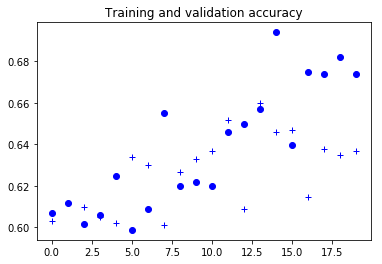

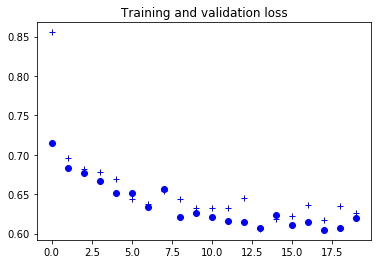

In [8]:
history = model.fit_generator(
      train_generator,
      steps_per_epoch=STEPS_PER_EPOCH,
      epochs=EPOCHS,
      callbacks = callbacks,
      validation_data=validation_generator,
      validation_steps=STEPS_PER_EPOCH)

model.save(model_file_path) 

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'b+')
plt.plot(epochs, val_acc, 'bo')
plt.title('Training and validation accuracy')

plt.figure()

plt.plot(epochs, loss, 'b+')
plt.plot(epochs, val_loss, 'bo')
plt.title('Training and validation loss')

plt.show()

### Test the model
Caculate the accuracy for the model  for the the test dataset by using a multi-threaded predictor API.

In [11]:
for curr_class in [POSITIVE_CLASS, NEGATIVE_CLASS]: 
    
    dir_name = join(test_dir, curr_class);
    no_of_samples = len(listdir(dir_name))
    
    test_generator = test_datagen.flow_from_directory(
            test_dir,
            target_size=(IMAGE_SIZE, IMAGE_SIZE),
            batch_size=BATCH_SIZE,
            classes = [curr_class],
            save_to_dir=aug_dir,
            save_format='jpeg',
            class_mode=None)
    predictions = model.predict_generator(test_generator, (no_of_samples // BATCH_SIZE) + 1, max_queue_size=10, workers=8, use_multiprocessing=False, verbose=0)
    predictions = np.asarray(predictions).flatten()
    correct_count = 0

    for idx, x in enumerate(predictions):
        if curr_class == POSITIVE_CLASS and x >= 0.5:
            correct_count += 1
        elif curr_class == NEGATIVE_CLASS and x < 0.5:
            correct_count += 1
    print(curr_class + ':' + str(correct_count / len(predictions) * 100))

Found 471 images belonging to 1 classes.
roads:61.146496815286625
Found 736 images belonging to 1 classes.
others:72.82608695652173
